# Initialize the Environment

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
os.environ['MKL_NUM_THREADS'] = '1'
import sys
import glob
import json
import subprocess
from multiprocessing import Pool

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as io
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams

import fig_plotting
rcParams = fig_plotting.update_rcparams(rcParams)

import scipy.stats as stats

os.chdir('../')
import Codebase
conv_adj_matr_to_cfg_matr = Codebase.Networks.configuration.convert_adj_matr_to_cfg_matr
conv_cfg_vec_to_adj_matr = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr
from Codebase.Networks.SubgraphDetection.nonnegfac import nmf
os.chdir('./Analysis_Notebooks/')

path_MetaData = '/home1/a/ankk/LittHome/Remotes/CORE.ieeg_ltm.multiinst/Raw_Neocortical'
path_CoreData = '/home1/a/ankk/LittHome/Remotes/CORE.ieeg_ltm.multiinst/Dyne_Neocortical/FuncConn.XCorr_WideBand.4_115/network'
path_PeriphData = '/home1/a/ankk/LittHome/Remotes/RSRCH.InterictalSubgraph'
path_ExpData = path_PeriphData + '/ds-e01-NMF_Optimization'

for path in [path_CoreData, path_PeriphData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

/home1/a/ankk/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Generate Data List

## Clinical Metadata

In [2]:
# Get clinical_metadata
df_meta = h5py.File('{}/clinical_metadata.mat'.format(path_MetaData), 'r')
meta_subj = [''.join(unichr(c) for c in df_meta[r])
             for r in df_meta['subject']['ID'][:, 0]]

## Aggregate good events

In [3]:
# Get subject list
subj_event = [full_subj_path
              for full_subj_path in glob.iglob('{}/*.dyne_output.hdf'.format(path_CoreData))]

# Check goodness of events through time x time condition number
def check_event(ev_path):    
    df_dyne = h5py.File(ev_path, 'r')
    
    adj = df_dyne[df_dyne.keys()[0]]['data'][:,:,:];
    triu_ix, triu_iy = np.triu_indices(adj.shape[1], k=1)
    cfg = adj[:, triu_ix, triu_iy]
    tt = np.corrcoef(cfg)
    
    df_dyne.close()
    
    try:
        cnd_num = np.linalg.cond(tt)
    except:
        cnd_num = np.nan
    
    return ev_path, cnd_num

# Parallelize it
import multiprocessing as mp
pool = mp.Pool(20)
good_ev_list = pool.map(check_event, subj_event)

# Cache the NMF result
np.savez("{}/NMF_Good_Events.npz".format(path_ExpData),
         event_list=good_ev_list)
print('Done!')

Done!


## Populate subject dictionary

In [3]:
# Read the Condition Checking Result
ev_list = np.load("{}/NMF_Good_Events.npz".format(path_ExpData))['event_list']

subj_dict = {}
good_ev_list = []
bad_ev_list = []
for path, cnd_num in ev_list:
    path = str(path)
    cnd_num = float(cnd_num)
    
    if np.isnan(cnd_num) or (cnd_num > 1e5):
        bad_ev_list.append(path)
        continue
    else:
        good_ev_list.append(path)

    full_id = path.split('/')[-1]
    subj_id = full_id.split('-')[0]
    epoch_id = full_id.split('-')[1]
    block_id = full_id.split('-')[3].split('.')[0]
    
    try:
        subj_dict[subj_id]
    except KeyError:
        subj_dict[subj_id] = {}

    try:
        subj_dict[subj_id][epoch_id]
    except KeyError:
        subj_dict[subj_id][epoch_id] = {}

    # Check that the path exists
    
    
    try:
        subj_dict[subj_id][epoch_id][block_id]
    except KeyError:
        subj_dict[subj_id][epoch_id][block_id] = {}
    
    subj_dict[subj_id][epoch_id][block_id] = \
               {'dyne_output': path,
                'dyne_log': '{}/{}-{}-block-{}.mat.dyne_log.csv'.format(path_CoreData,
                                                                        subj_id, epoch_id, block_id)
               }

# NMF Parameter Optimization

## Set search space and Assign interictal block to each parameter ID

In [11]:
alpha = 0.0
beta = 0.0
rank = [2, 20]
n_run = 50

# Generate parameter set
proc_item = []
for subj_id in subj_dict.keys():
    epoch_id = 'interictal'
    block_ids = np.random.permutation(subj_dict[subj_id]['interictal'].keys())    
    
    param_id = 1
    for run_i in xrange(n_run):
        block_id = block_ids[run_i]
        for rnk in xrange(rank[0], rank[1]+1):

            param = {'id': param_id,
                     'alpha': alpha,
                     'beta': beta,
                     'rank': rnk}
            param_id += 1
            
            proc_dict = {'data_path': subj_dict[subj_id][epoch_id][block_id],
                         'output_name': '{}.{}.{}.{}'.format(subj_id, epoch_id, block_id, param['id']),
                         'param_set': param}
            proc_item.append(proc_dict)
        
np.savez('{}/NMF_Optimization.Param_Search_Space.npz'.format(path_ExpData),
         proc_item=proc_item)

## Run NMF on Proc_Item List

In [4]:
parallel_run = True
proc_item = np.load('{}/NMF_Optimization.Param_Search_Space.npz'.format(path_ExpData))['proc_item']

# Remove already completed items from proc list
new_proc_item = []
for pitem in proc_item:
    if not os.path.exists("{}/{}.npz".format(path_ExpData, pitem['output_name'])):
        new_proc_item.append(pitem)
proc_item = new_proc_item

# Setup helper function to map NMF run
def _start_helper(pitem):
    print('Processing: {}'.format(pitem['output_name']))
    
    # Getting Data from Dyne
    df_log = pd.read_csv(pitem['data_path']['dyne_log'], delimiter=',')
    pipe_hash = np.array(df_log[df_log.PIPE_NAME == 'CrossCorrelation'].DOWNSTREAM_HASH)[0]
    df_outp = h5py.File(pitem['data_path']['dyne_output'], 'r')
    cfg_matr = conv_adj_matr_to_cfg_matr(df_outp[pipe_hash]['data'][...])
    
    # Setup NMF
    cfg_matr = np.nan_to_num(cfg_matr)
    n_win = cfg_matr.shape[0]
    n_conn = cfg_matr.shape[1]
        
    # Initialize the factors for NMF
    fac_subnet = np.random.uniform(low=0, high=1.0,
                                   size=(pitem['param_set']['rank'],
                                         n_conn))
    fac_coef = np.random.uniform(low=0, high=1.0,
                                 size=(pitem['param_set']['rank'],
                                       n_win))

    # Run NMF Algorithm
    try:
        fac_subnet, fac_coef, err = nmf.snmf_bcd(
            cfg_matr,
            alpha=pitem['param_set']['alpha'],
            beta=pitem['param_set']['beta'],
            fac_subnet_init=fac_subnet,
            fac_coef_init=fac_coef,
            max_iter=100, verbose=False)
    except np.linalg.linalg.LinAlgError as e:
        print(e)
        return 0
        
    # Cache the NMF result
    np.savez("{}/{}.npz".format(path_ExpData, pitem['output_name']),
             fac_subnet=fac_subnet, fac_coef=fac_coef, err=err,
             param_set=pitem['param_set'])
    
if parallel_run:
    mp = Pool(20)
    mp.map(_start_helper, proc_item)
else:
    map(_start_helper, proc_item)

## Plot Optimum Rank

MAYO023


/home1/a/ankk/Developer/miniconda2/envs/cb-resection/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


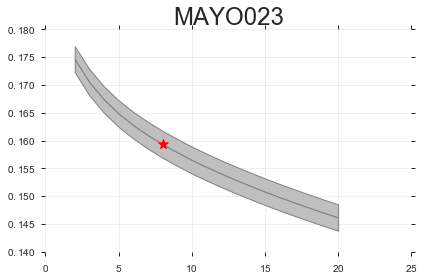

MAYO020


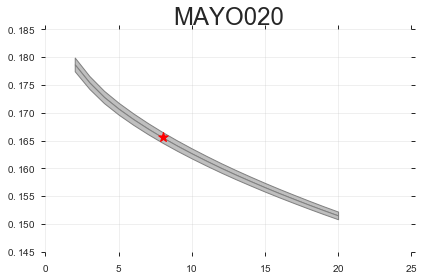

HUP68


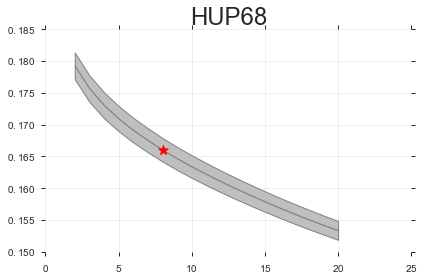

MAYO026


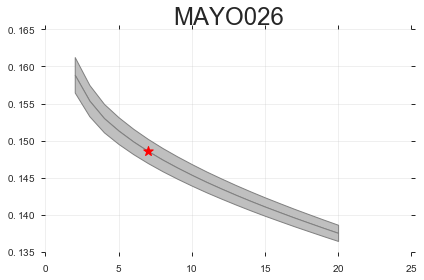

MAYO031


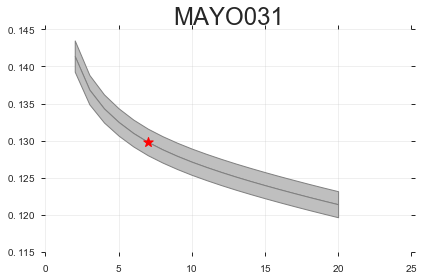

HUP64


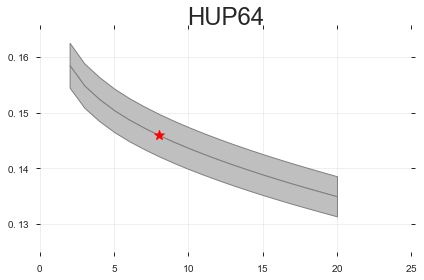

HUP65


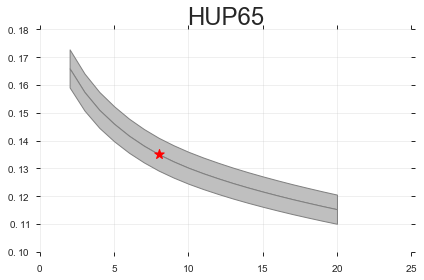

MAYO006


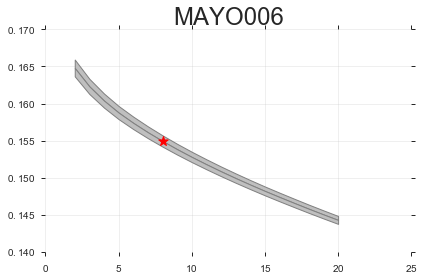

MAYO033


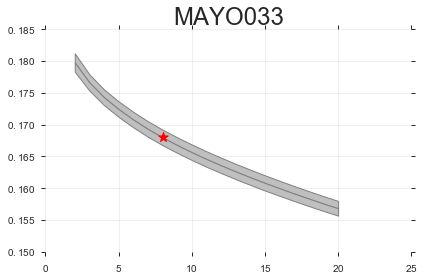

MAYO019


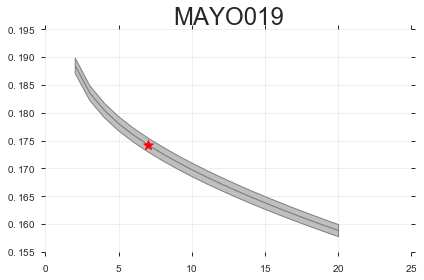

MAYO004


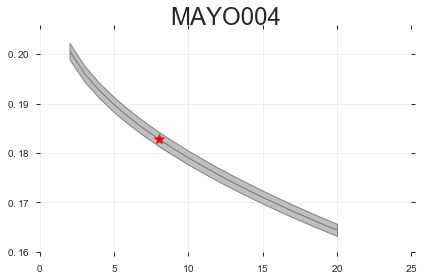

HUP79


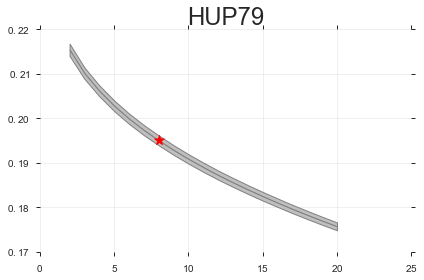

HUP73


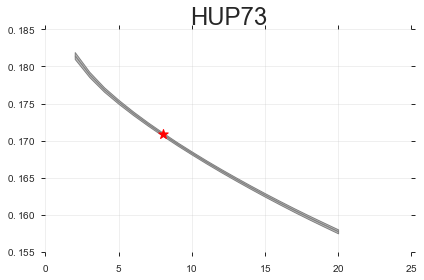

HUP72


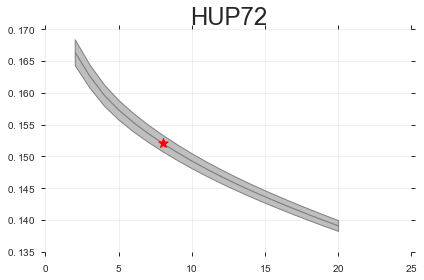

HUP70


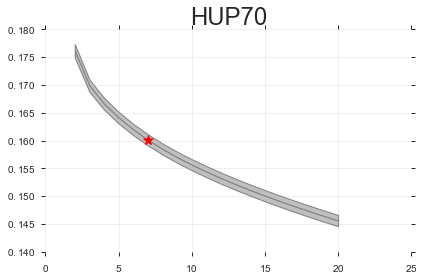

MAYO037


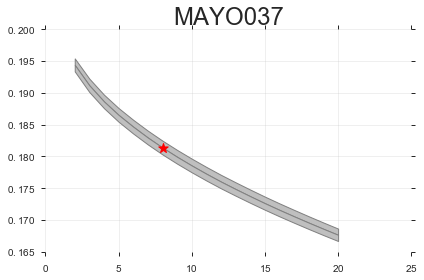

MAYO010


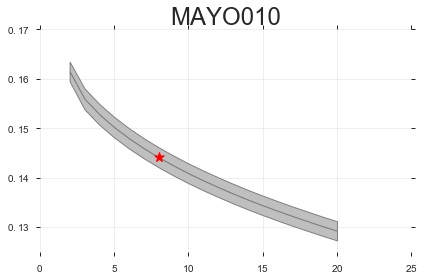

MAYO011


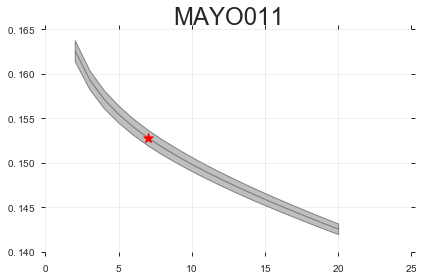

MAYO016


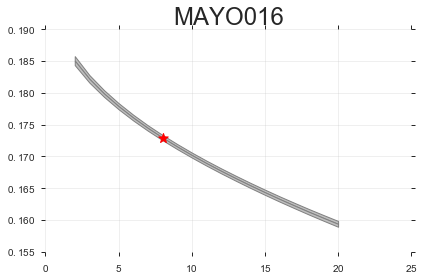

HUP78


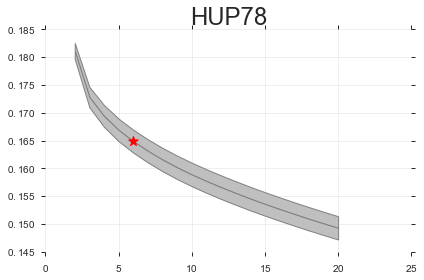

HUP86


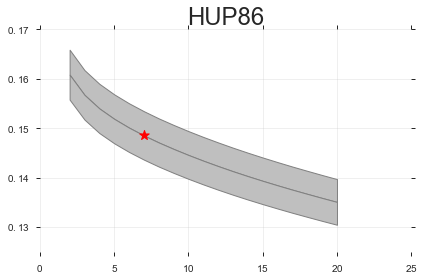

HUP87


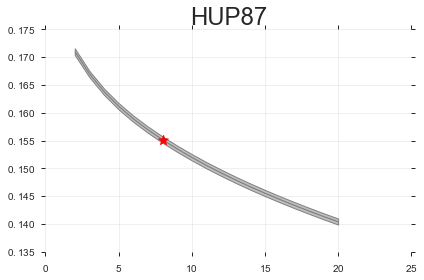

In [5]:
%matplotlib inline
for subj_id in subj_dict.keys():
    print(subj_id)
    opt_paths = glob.glob('{}/{}.interictal.*.*.npz'.format(path_ExpData, subj_id))
    
    recons_error = np.zeros((len(opt_paths), 2))
    for path_ii, opt_path in enumerate(opt_paths):
        df_opt = np.load(opt_path, mmap_mode='r')
        recons_error[path_ii, 0] = df_opt['fac_subnet'].shape[0]        
        recons_error[path_ii, 1] = df_opt['err'][-1]
    
    n_fac_list = np.unique(recons_error[:, 0])
    recons_error_mean = np.zeros(len(n_fac_list))
    recons_error_std = np.zeros(len(n_fac_list))
    for fac_ii, fac_id in enumerate(n_fac_list):
        fac_ix = np.flatnonzero(recons_error[:, 0] == fac_id)
        recons_error_mean[fac_ii] = recons_error[fac_ix, 1].mean()
        recons_error_std[fac_ii] = recons_error[fac_ix, 1].std() / np.sqrt(len(fac_ix))
    
    plt.figure()
    ax = plt.subplot(111)
    ax.fill_between(n_fac_list, recons_error_mean, recons_error_mean+recons_error_std)
    ax.fill_between(n_fac_list, recons_error_mean, recons_error_mean-recons_error_std)    
    opt_ix = Codebase.Utilities.optimization.find_elbow(recons_error_mean)
    ax.scatter(n_fac_list[opt_ix], recons_error_mean[opt_ix], color='r', marker='*', s=100.0)
    ax.set_title(subj_id)
    plt.show()    
    
    np.savez('{}/{}.Num_Subgraph.npz'.format(path_ExpData, subj_id),
         n_subgraph=n_fac_list[opt_ix])

(-1, 8)

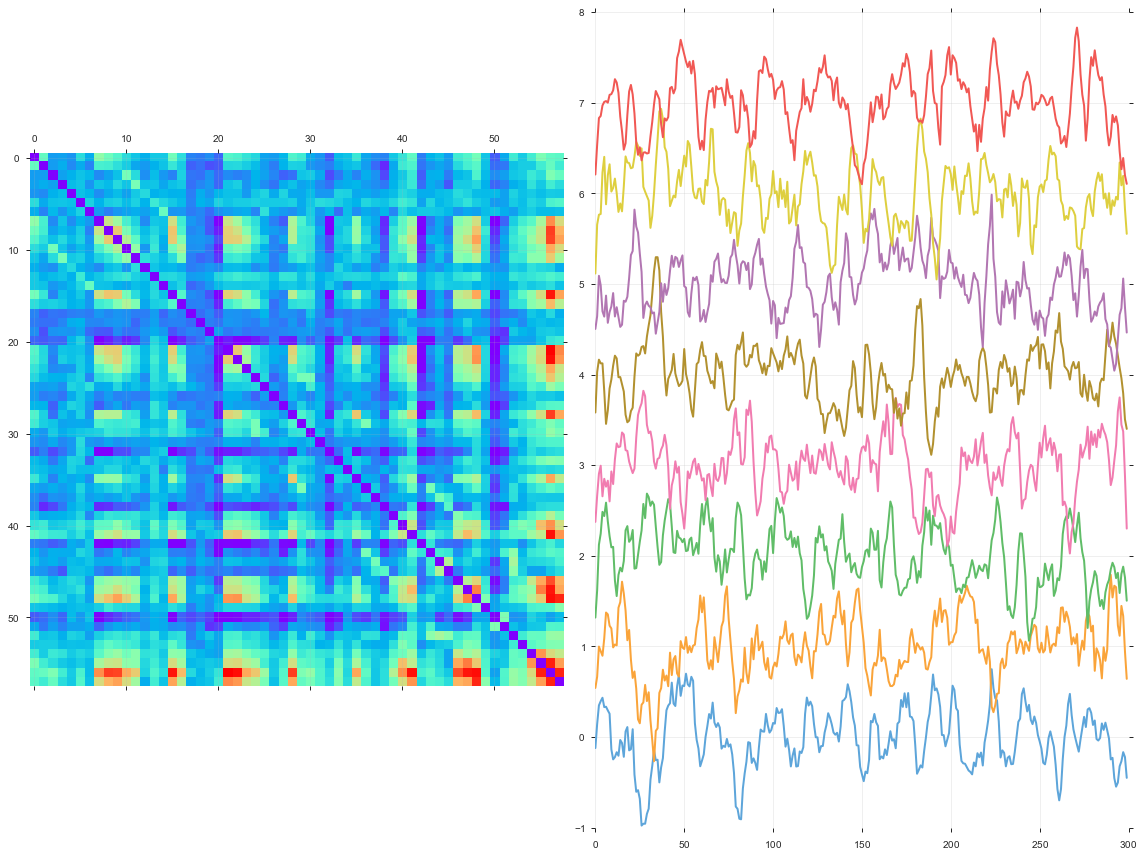

In [15]:
%matplotlib inline


plt.figure(figsize=(16,12))
ax = plt.subplot(1,2,1)
ax.matshow(conv_cfg_vec_to_adj_matr(df_opt['fac_subnet'][2, :]), cmap='rainbow')

ax = plt.subplot(1,2,2)
for ii in xrange(df_opt['fac_coef'].shape[0]):
    fac_coef = 1/5. * np.convolve(np.ones(5), df_opt['fac_coef'][ii, :], mode='same')
    fac_coef = (fac_coef - fac_coef.mean()) / (3*fac_coef.std())
    ax.plot(np.arange(len(fac_coef)),
            fac_coef+ii)
ax.set_ylim([-1, ii+1])